<a href="https://colab.research.google.com/github/Saba-a11/Kaggle_Credit_Score/blob/main/CreditModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
from ast import increment_lineno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
sns.set_palette('plasma')    # magma, crest, rocket_r, flare, mako, rocket, viridis, plasma, cividis
sns.set_style('whitegrid')


def prt_corr(df, column_of_interest, target_column):
  # Calculate the correlation
  correlation = df[column_of_interest].corr(df[target_column])
  print(f"Correlation between {column_of_interest} and {target_column}: {correlation}")


def scatter_plot(df, column_of_interest, target_column):
  # Scatter plot
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=df[column_of_interest], y=df[target_column])
  plt.title(f'Scatter Plot between {column_of_interest} and {target_column}')
  plt.xlabel(column_of_interest)
  plt.ylabel(target_column)
  plt.show()


def heatmap_plot(df):
  # Create a heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(df, annot=True, cmap='coolwarm', linewidths=.5)
  plt.title('Heatmap for the Dataset')
  plt.show()


def calculate_woe_iv(data, target_col, feature_col, bins=10):
    """
    Calculate Weight of Evidence (WOE) and Information Value (IV) for a given feature.

    Parameters:
    - data: DataFrame containing the dataset.
    - target_col: Name of the target column.
    - feature_col: Name of the feature column for which WOE and IV are calculated.
    - bins: Number of bins for binning the continuous variable.

    Returns:
    - woe_iv_df: DataFrame containing WOE and IV values for each bin.
    """

    # Create bins for the feature variable
    data['bins'], bin_edges = pd.qcut(data[feature_col], q=bins, retbins=True, duplicates='drop')

    # Create a summary table
    summary_table = pd.crosstab(data['bins'], data[target_col])

    # Calculate WOE for each bin
    summary_table['woe'] = np.log((summary_table[0] / summary_table[0].sum()) / (summary_table[1] / summary_table[1].sum()))

    # Calculate IV for each bin
    summary_table['iv'] = (summary_table[0] / summary_table[0].sum() - summary_table[1] / summary_table[1].sum()) * summary_table['woe']

    # Calculate overall IV for the variable
    iv = summary_table['iv'].sum()

    # Create a DataFrame with WOE and IV values
    woe_iv_df = summary_table[['woe', 'iv']].reset_index()

    # Add number of observations column
    woe_iv_df['observations'] = data.groupby('bins').size().reset_index(name='observations')['observations']

    # Add column names
    woe_iv_df.columns = ['bin', 'woe', 'iv', 'observations']

    # Display overall IV
    print(f"Overall IV for {feature_col}: {iv}")

    return woe_iv_df

# df_woe = combined_data[combined_data['dataset'] == 'train']
# woe_iv_result = calculate_woe_iv(df_woe, 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', bins=10)
# print(woe_iv_result)


def calculate_discrete_woe_iv(data, target_col, feature_col):
    """
    Calculate Weight of Evidence (WOE) and Information Value (IV) for a given discrete feature.

    Parameters:
    - data: DataFrame containing the dataset.
    - target_col: Name of the target column.
    - feature_col: Name of the feature column for which WOE and IV are calculated.

    Returns:
    - woe_iv_df: DataFrame containing WOE and IV values for each category.
    """

    # Create a summary table
    summary_table = pd.crosstab(data[feature_col], data[target_col])

    # Calculate WOE for each category
    summary_table['woe'] = np.log((summary_table[0] / summary_table[0].sum()) / (summary_table[1] / summary_table[1].sum()))

    # Calculate IV for each category
    summary_table['iv'] = (summary_table[0] / summary_table[0].sum() - summary_table[1] / summary_table[1].sum()) * summary_table['woe']

    # Calculate overall IV for the variable
    iv = summary_table['iv'].sum()

    # Create a DataFrame with WOE and IV values
    woe_iv_df = summary_table[['woe', 'iv']].reset_index()

    # Add number of observations column
    woe_iv_df['observations'] = summary_table.sum(axis=1)

    # Add column names
    woe_iv_df.columns = [feature_col, 'woe', 'iv', 'observations']

    # Display overall IV
    print(f"Overall IV for {feature_col}: {iv}")

    return woe_iv_df


def plot_woe(df, rotation_x_axis = 0):
  x = np.array(df.iloc[:, 0].apply(str))
  y = df['woe']
  plt.figure(figsize = (18, 6))
  plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
  plt.xlabel(df.columns[0])
  plt.ylabel('Weight of Evidence')
  plt.title(str('Weight of Evidence by ' + df.columns[0]))
  plt.grid(True)
  plt.xticks(rotation = rotation_x_axis)

# plot_woe(woe_iv_result)

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-training.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Data_Kaggle_GiveMeSomeCredit/cs-test.csv")

In [5]:
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
1,2,0,0.96,40,0,0.12,"2,600.00",4,0,0,0,1.00
2,3,0,0.66,38,1,0.09,"3,042.00",2,1,0,0,0.00
3,4,0,0.23,30,0,0.04,"3,300.00",5,0,0,0,0.00
4,5,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00


In [6]:
df_test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.89,43,0,0.18,"5,700.00",4,0,0,0,0.00
1,2,NaN,0.46,57,0,0.53,"9,141.00",15,0,4,0,2.00
2,3,NaN,0.04,59,0,0.69,"5,083.00",12,0,1,0,2.00
3,4,NaN,0.28,38,1,0.93,"3,200.00",7,0,2,0,0.00
4,5,NaN,1.00,27,0,0.02,"3,865.00",4,0,0,0,1.00


### based on Data Dictionary, Variable Name, Description and Type are:

* `SeriousDlqin2yrs` Person experienced 90 days past due delinquency or
worse. **Y/N**
* `RevolvingUtilizationOfUnsecuredLines` Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits. **percentage**
* `age` Age of borrower in years. **integer**
* `NumberOfTime3059DaysPastDueNotWorse` Number of times borrower has been 30-59 days past due but no worse in the last 2 years. **integer**
* `DebtRatio` Monthly debt payments, alimony,living costs divided by monthy gross income **percentage**
* `MonthlyIncome Monthly` income **real**
* `NumberOfOpenCreditLinesAndLoans` Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) **integer**
* `NumberOfTimes90DaysLate` Number of times borrower has been 90 days or more past due. **integer**
* `NumberRealEstateLoansOrLines` Number of mortgage and real estate loans including home equity lines of credit **integer**
* `NumberOfTime60-89DaysPastDueNotWorse` Number of times borrower has been 60-89 days past due but no worse in the last 2 years. **integer**
* `NumberOfDependents` Number of dependents in family excluding themselves (spouse, children etc.) **integer**

# Exploratory Data Analysis

In [7]:
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (150000, 12)
Test shape:  (101503, 12)


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [9]:
df_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","150,000.00","120,269.00","150,000.00","150,000.00","150,000.00","150,000.00","146,076.00"
mean,"75,000.50",0.07,6.05,52.30,0.42,353.01,"6,670.22",8.45,0.27,1.02,0.24,0.76
std,"43,301.41",0.25,249.76,14.77,4.19,"2,037.82","14,384.67",5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"37,500.75",0.00,0.03,41.00,0.00,0.18,"3,400.00",5.00,0.00,0.00,0.00,0.00
50%,"75,000.50",0.00,0.15,52.00,0.00,0.37,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,"112,500.25",0.00,0.56,63.00,0.00,0.87,"8,249.00",11.00,0.00,2.00,0.00,1.00
max,"150,000.00",1.00,"50,708.00",109.00,98.00,"329,664.00","3,008,750.00",58.00,98.00,54.00,98.00,20.00


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [11]:
df_test.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,"101,503.00",0.00,"101,503.00","101,503.00","101,503.00","101,503.00","81,400.00","101,503.00","101,503.00","101,503.00","101,503.00","98,877.00"
mean,"50,752.00",NaN,5.31,52.41,0.45,344.48,"6,855.04",8.45,0.30,1.01,0.27,0.77
std,"29,301.54",NaN,196.16,14.78,4.54,"1,632.60","36,508.60",5.14,4.52,1.11,4.50,1.14
min,1.00,NaN,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"25,376.50",NaN,0.03,41.00,0.00,0.17,"3,408.00",5.00,0.00,0.00,0.00,0.00
50%,"50,752.00",NaN,0.15,52.00,0.00,0.36,"5,400.00",8.00,0.00,1.00,0.00,0.00
75%,"76,127.50",NaN,0.56,63.00,0.00,0.85,"8,200.00",11.00,0.00,2.00,0.00,1.00
max,"101,503.00",NaN,"21,821.00",104.00,98.00,"268,326.00","7,727,000.00",85.00,98.00,37.00,98.00,43.00


## Finding:


* `Unnamed: 0` column is deemed redundant and is recommended for deletion.
* `SeriousDlqin2yrs` column serves as the target column, and with over 75% of its data containing a value of 0, an imbalance is observed.
* `RevolvingUtilizationOfUnsecuredLines` column, the presence of outlier values is indicated by the maximum value.
* `age` column requires rectification as it holds a minimum value of 0.Additionally, the maximum age of 109 may be considered uncommon.
* `DebtRatio` column, the identification of outlier values is suggested due to the maximum value.
* Both columns `MonthlyIncome` and `NumberOfDependents` exhibit null values, necessitating appropriate handling procedures.
* Across the remaining columns, an examination based on the comparison of Q3 and maximum values reveals the presence of outliers.
* The preliminary analysis of the **train** and **test** datasets indicates a congruent behavior between the two. Consequently, we opt to merge them during the data preprocessing phase for streamlined processing and analysis.



# Data Preprocessing

### Unnamed: 0 Column

The column labeled `Unnamed: 0` lacks significance within the context of predictive modeling, serving solely as a representation of customer identification. Rename this column to `ID` for future reference, It will not play a role in the modeling process.

In [4]:
df_train.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
df_test.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

### SeriousDlqin2yrs Column

An imbalanced target column in a dataset, particularly in the context of binary classification, implies that the distribution of the classes is uneven. `SeriousDlqin2yrs` column has an imbalance, with a default rate of **6.7%**.

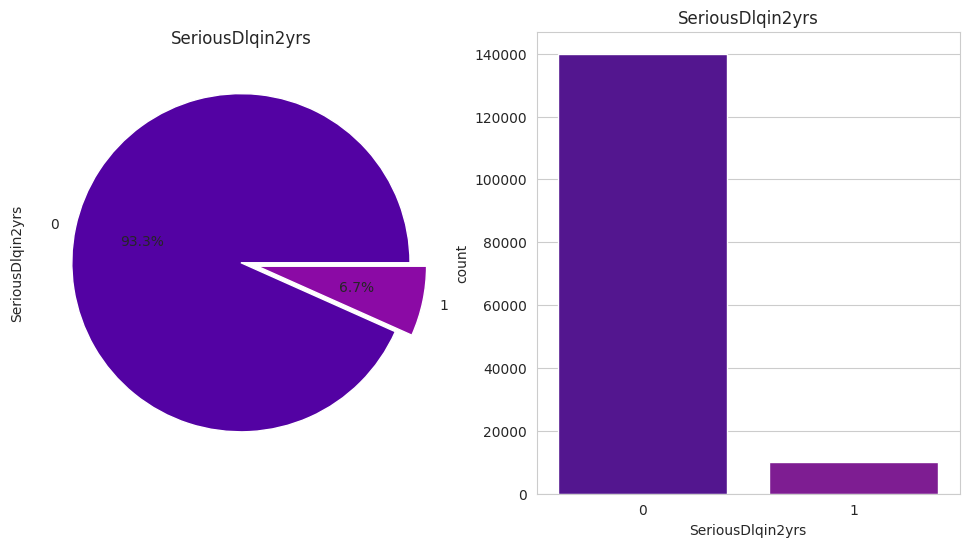

In [14]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

df_train['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')

sns.countplot(x='SeriousDlqin2yrs', data=df_train, ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')

plt.show()



### Consequences of Imbalanced Data:
**Bias Towards Majority Class:** Machine learning models trained on imbalanced data may exhibit a bias
toward the majority class. In your case, this could mean the model is more inclined to predict non-default.

**Reduced Sensitivity to Minority Class:** The model may have difficulty correctly predicting instances of the minority class (defaults) due to its lower prevalence.

### Strategies to Balance the Data:
**Resampling:**
  * **Oversampling Minority Class:** Increase the number of instances in the minority class to balance the class distribution.
  * **Undersampling Majority Class:** Decrease the number of instances in the majority class to achieve a balanced dataset.

**Synthetic Data Generation:** Use techniques like Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic examples for the minority class.

**Algorithmic Approaches:** Utilize algorithms designed to handle imbalanced datasets, such as ensemble methods like Balanced Random Forest or algorithms with class weight adjustments.

**Evaluation Metrics:** Instead of solely relying on accuracy, use metrics like precision, recall, F1-score, or area under the ROC curve (AUC-ROC) that are more informative for imbalanced datasets.

In [5]:
# Assuming train and test are dataframes
# Add a column to each indicating their origin

df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

# Concatenate the two dataframes
combined_data = pd.concat([df_train, df_test], ignore_index=True)

In [6]:
print('Combined data shape: ', combined_data.shape)

Combined data shape:  (251503, 13)


In [7]:
# check if exist any duplicated data
print(combined_data.duplicated().value_counts())

False    251503
dtype: int64


In [ ]:
columns_to_exclude = ['ID', 'dataset']
selected_columns = df_train.drop(columns=columns_to_exclude)
heatmap_plot(selected_columns)

### RevolvingUtilizationOfUnsecuredLines Column

In [31]:
combined_data[["RevolvingUtilizationOfUnsecuredLines"]].describe()

,RevolvingUtilizationOfUnsecuredLines
count,"251,503.00"
mean,0.32
std,0.35
min,0.00
25%,0.03
50%,0.15
75%,0.56
max,1.00


In [9]:
prt_corr(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: -0.0018015025039439683


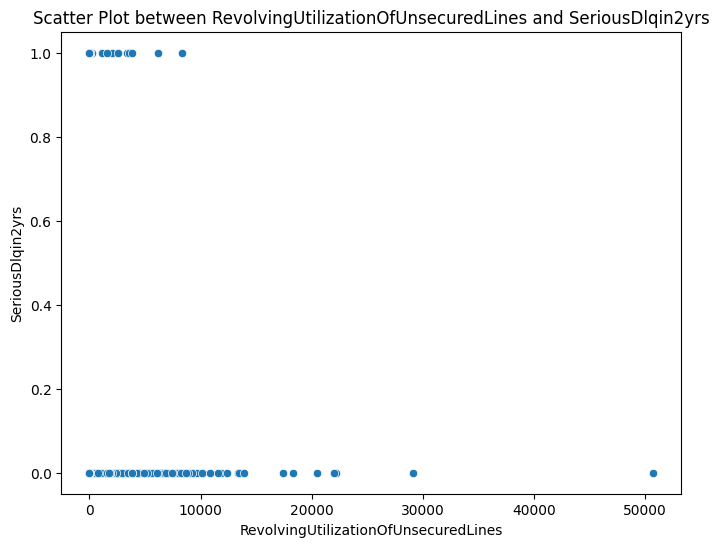

In [23]:
scatter_plot(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

In [10]:
print("Number of RevolvingUtilizationOfUnsecuredLines that are more than 1:", len(combined_data[combined_data['RevolvingUtilizationOfUnsecuredLines'] > 1]))

Number of RevolvingUtilizationOfUnsecuredLines that are more than 1: 5502


In [30]:
combined_data['RevolvingUtilizationOfUnsecuredLines'] = combined_data['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: 1 if x > 1 else x)

combined_data[['RevolvingUtilizationOfUnsecuredLines']].describe()

,RevolvingUtilizationOfUnsecuredLines
count,"251,503.00"
mean,0.32
std,0.35
min,0.00
25%,0.03
50%,0.15
75%,0.56
max,1.00


In [12]:
prt_corr(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

Correlation between RevolvingUtilizationOfUnsecuredLines and SeriousDlqin2yrs: 0.27809636823708855


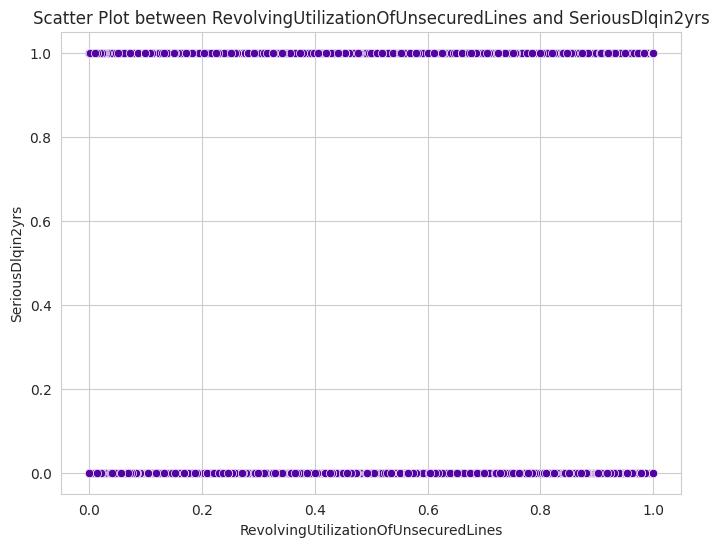

In [13]:
scatter_plot(combined_data,'RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs')

### Age Column

In [29]:
combined_data[["age"]].describe()

,age
count,"251,503.00"
mean,52.34
std,14.77
min,21.00
25%,41.00
50%,52.00
75%,63.00
max,109.00


In [15]:
zero_age_count = (combined_data['age'] == 0).sum()
print(f"Number of values equal to zero in the 'age' column: {zero_age_count}")

Number of values equal to zero in the 'age' column: 1


In [16]:
# Impute age=0 with the median age
median_age = combined_data['age'].median()
combined_data['age'] = combined_data['age'].replace(0, median_age)

Dealing with outliers in the `age` column is essential for building accurate models. In your case, you've identified that there are instances where age is recorded as 0, which is likely an error or missing data. Here are steps to handle this situation:

**Identify and Handle Outliers:**
1. **Imputation:** If the number of instances with age = 0 is small, you may consider imputing these values with a reasonable estimate. This could be the mean or median age, depending on the distribution of the rest of the data.

2. **Remove Incorrect Data:** If the instances with age = 0 are an error or cannot be reasonably imputed, consider removing those rows from your dataset.

3. **Set a Threshold:** If the age=0 is unrealistic and indicates a data entry error, you can set a threshold below which values are considered invalid (e.g., age < 18), and either remove or impute those values.

In [17]:
prt_corr(combined_data, 'age', 'SeriousDlqin2yrs')

Correlation between age and SeriousDlqin2yrs: -0.11539662019283052


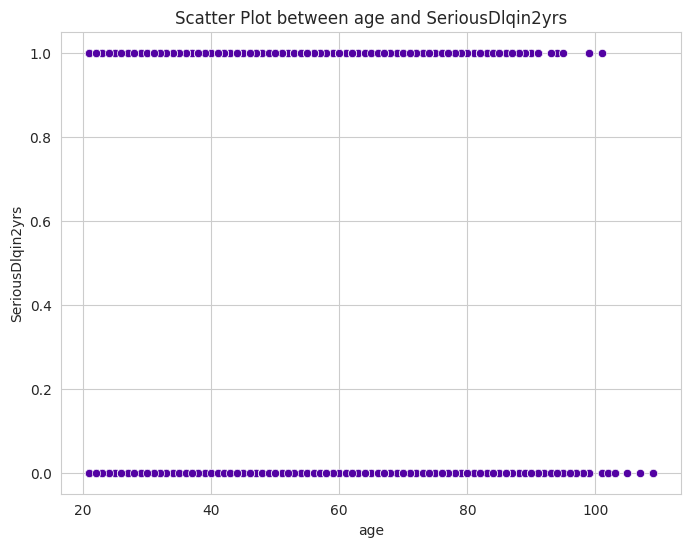

In [18]:
scatter_plot(combined_data, 'age', 'SeriousDlqin2yrs')

### Overdue Payment Indicators

* `NumberOfTimes90DaysLate`
* `NumberOfTime60-89DaysPastDueNotWorse`
* `NumberOfTime30-59DaysPastDueNotWorse`

In [19]:
late_pay_cols = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate"]
combined_data[late_pay_cols].describe()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,"251,503.00","251,503.00","251,503.00"
mean,0.43,0.25,0.28
std,4.34,4.30,4.31
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
max,98.00,98.00,98.00


In [22]:
# Create three tables
count_90_days = combined_data["NumberOfTimes90DaysLate"].value_counts().sort_index()
count_60_89_days = combined_data["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()
count_30_59_days = combined_data["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

# Concatenate the value counts into a single DataFrame
result_df = pd.concat([count_90_days, count_60_89_days, count_30_59_days], axis=1)

# Rename the columns for clarity
result_df.columns = ['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse']

# Display the resulting DataFrame
print(result_df.to_string())

    NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTime30-59DaysPastDueNotWorse
0                237,447.00                            238,771.00                            211,208.00
1                  8,837.00                              9,594.00                             26,870.00
2                  2,617.00                              1,849.00                              7,766.00
3                  1,112.00                                534.00                              2,955.00
4                    482.00                                166.00                              1,257.00
5                    233.00                                 59.00                                547.00
6                    124.00                                 23.00                                228.00
7                     64.00                                 16.00                                 96.00
8                     40.00                                  3.0

In [23]:
def replace_96_98(data):
    """ Purpose: To replace the spurious values 96 or 98 with the median from the feature. """
    # Remove the 96 and 98 values from the median calculation.
    new_data = data[data!=96]
    new_data = new_data[new_data!=98]

    new = []
    newval = new_data.median()
    for i in data:
        if (i == 96 or i == 98):
            new.append(newval)
        else:
            new.append(i)
    return new

combined_data['NumberOfTime30-59DaysPastDueNotWorse'] = replace_96_98(combined_data['NumberOfTime30-59DaysPastDueNotWorse'])
combined_data['NumberOfTime60-89DaysPastDueNotWorse'] = replace_96_98(combined_data['NumberOfTime60-89DaysPastDueNotWorse'])
combined_data['NumberOfTimes90DaysLate'] = replace_96_98(combined_data['NumberOfTimes90DaysLate'])

In [100]:
# Remove rows with suspicious values (96 and 98)
# combined_data = combined_data[~combined_data["NumberOfTimes90DaysLate"].isin([96, 98])]

In [24]:
combined_data[late_pay_cols].describe()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,"251,503.00","251,503.00","251,503.00"
mean,0.25,0.06,0.09
std,0.70,0.33,0.48
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,0.00
max,19.00,11.00,18.00


In [25]:
# Calculate the correlation
df_corr = combined_data[["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "SeriousDlqin2yrs"]]

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Print the correlation matrix
print(correlation_matrix.to_string())

                                      NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate  SeriousDlqin2yrs
NumberOfTime30-59DaysPastDueNotWorse                                  1.00                                  0.31                     0.21              0.27
NumberOfTime60-89DaysPastDueNotWorse                                  0.31                                  1.00                     0.30              0.27
NumberOfTimes90DaysLate                                               0.21                                  0.30                     1.00              0.31
SeriousDlqin2yrs                                                      0.27                                  0.27                     0.31              1.00


### DebtRatio

In [28]:
combined_data[["DebtRatio"]].describe()

,DebtRatio
count,"251,503.00"
mean,349.56
std,"1,884.79"
min,0.00
25%,0.17
50%,0.37
75%,0.86
max,"329,664.00"


**Minimum (min):** The minimum DebtRatio is 0. This suggests that there are entries where the debt payments, alimony, and living costs are effectively zero or extremely low compared to the gross income percentage.

**Maximum (max):** The maximum DebtRatio is very high at 329,664. This suggests the presence of outliers in the data.

In [35]:
pd.concat([combined_data.loc[combined_data["DebtRatio"] == 0][["MonthlyIncome"]].describe().rename(columns={"MonthlyIncome": "MonthlyIncome (DebtRatio = 0)"}), combined_data[["MonthlyIncome"]].describe()], axis=1)

,MonthlyIncome (DebtRatio = 0),MonthlyIncome
count,"4,143.00","201,669.00"
mean,"4,154.11","6,744.82"
std,"12,338.29","25,717.61"
min,0.00,0.00
25%,"1,630.50","3,400.00"
50%,"3,000.00","5,400.00"
75%,"5,000.00","8,212.00"
max,"629,000.00","7,727,000.00"


Given that 75% of the entries with `DebtRatio` equal to 0 have a `MonthlyIncome` below 5,000, it suggests that the value 0 for `DebtRatio` may be inaccurate or missing data.

**For handling this situation:**

Imputation: If the `DebtRatio` being 0 is likely a mistake, you could consider imputing values based on the distribution of `DebtRatio` for other entries with similar income levels.

**`DebtRatio` column**

The descriptive statistics for the `DebtRatio` column suggest that there might be some extreme outliers, given the large standard deviation and the maximum value being significantly higher than the 75th percentile.

Handling outliers is important to ensure that they don't unduly influence your analysis. Here are a few approaches to handle extreme values in the `DebtRatio` column:

**Data Truncation:**
* You can remove rows where the `DebtRatio` value is above a certain threshold, considering that extremely high values might be outliers or errors.

**Data Transformation:**
* Apply a transformation to the `DebtRatio` column to reduce the impact of extreme values. Common transformations include logarithmic transformation.

**Winsorizing:**
* Replace extreme values with a specified percentile value to reduce their impact.

In [37]:
combined_data.loc[(combined_data["MonthlyIncome"] < 3000) & ~(combined_data["DebtRatio"] == 0) ][["DebtRatio"]].describe()

,DebtRatio
count,"36,824.00"
mean,149.11
std,"1,557.41"
min,0.00
25%,0.15
50%,0.39
75%,0.91
max,"202,990.00"


In [43]:
# Set this value for all data that DetRatio is zero.
combined_data.loc[(combined_data["MonthlyIncome"] < 3000) & ~(combined_data["DebtRatio"] == 0) ]["DebtRatio"].quantile(0.5)

0.393114936

In [41]:
combined_data["DebtRatio"].quantile(0.766)

1.0

In [42]:
len(combined_data[(combined_data["DebtRatio"] > combined_data["DebtRatio"].quantile(0.766))])

58715

In [44]:
# Set lower bound for DebtRatio is zero and upper bound for DebtRatio more than 1
upper_bound = combined_data['DebtRatio'].quantile(0.766)
lower_bound = combined_data.loc[(combined_data["MonthlyIncome"] < 3000) & ~(combined_data["DebtRatio"] == 0) ]["DebtRatio"].quantile(0.5)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['DebtRatio'] > upper_bound, 'DebtRatio'] = upper_bound
combined_data.loc[combined_data['DebtRatio'] == 0, 'DebtRatio'] = lower_bound

In [45]:
prt_corr(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

Correlation between DebtRatio and SeriousDlqin2yrs: 0.025687775973780917


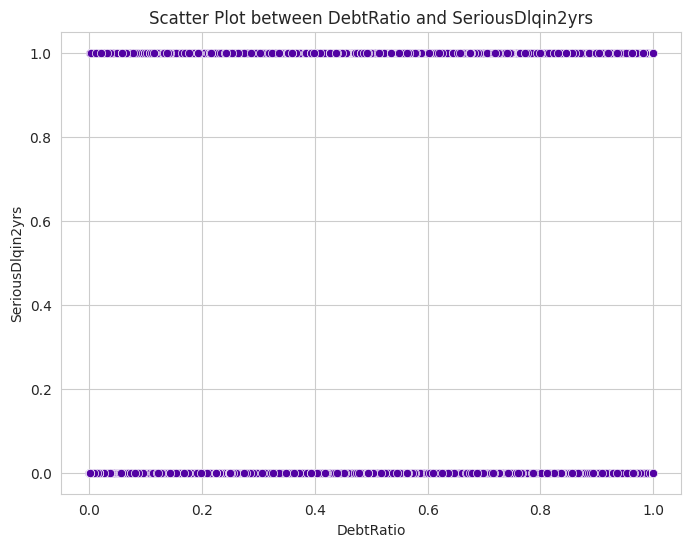

In [46]:
scatter_plot(combined_data, 'DebtRatio', 'SeriousDlqin2yrs')

### NumberOfOpenCreditLinesAndLoans Column

In [66]:
combined_data[["NumberOfOpenCreditLinesAndLoans"]].describe()

,NumberOfOpenCreditLinesAndLoans
count,"251,503.00"
mean,6.29
std,2.21
min,0.00
25%,5.00
50%,8.00
75%,8.00
max,8.00


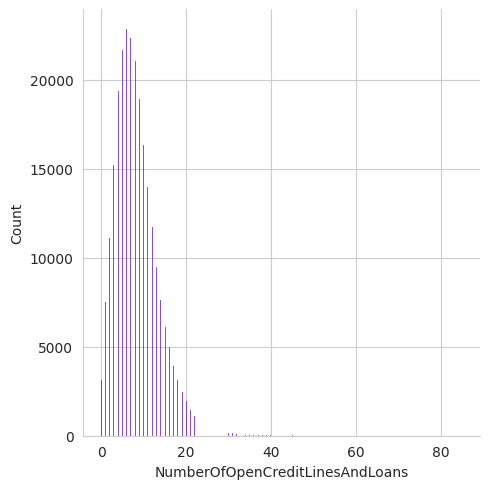

In [48]:
sns.displot(combined_data["NumberOfOpenCreditLinesAndLoans"])

In [55]:
prt_corr(combined_data, 'NumberOfOpenCreditLinesAndLoans', 'SeriousDlqin2yrs')

Correlation between NumberOfOpenCreditLinesAndLoans and SeriousDlqin2yrs: -0.029668568469318504


In [64]:
upper_bound = combined_data["NumberOfOpenCreditLinesAndLoans"].quantile(0.5)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberOfOpenCreditLinesAndLoans'] > upper_bound, 'NumberOfOpenCreditLinesAndLoans'] = upper_bound

In [65]:
prt_corr(combined_data, 'NumberOfOpenCreditLinesAndLoans', 'SeriousDlqin2yrs')

Correlation between NumberOfOpenCreditLinesAndLoans and SeriousDlqin2yrs: -0.06670537684812043


### umberRealEstateLoansOrLines Column

In [69]:
combined_data[["NumberRealEstateLoansOrLines"]].describe([0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

,NumberRealEstateLoansOrLines
count,"251,503.00"
mean,1.02
std,1.12
min,0.00
25%,0.00
50%,1.00
75%,2.00
80%,2.00
90%,2.00
95%,3.00


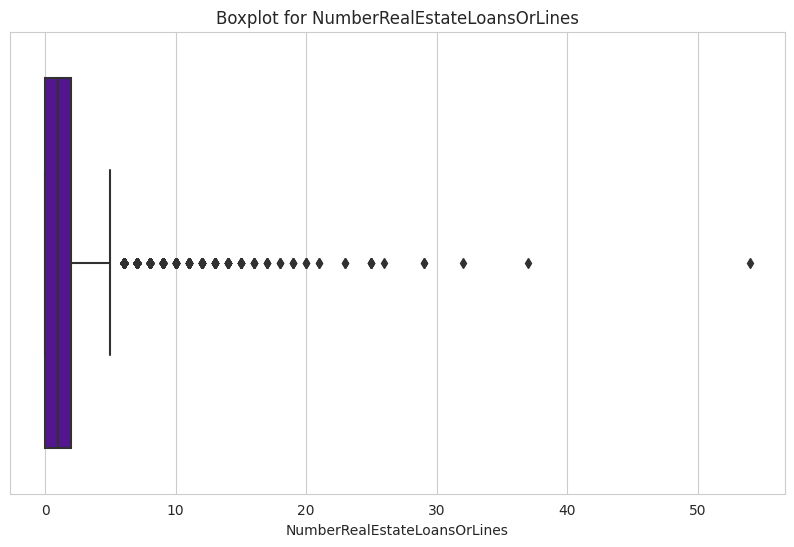

In [51]:
# Assuming combined_data is your DataFrame
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_data['NumberRealEstateLoansOrLines'])
plt.title('Boxplot for NumberRealEstateLoansOrLines')
plt.xlabel('NumberRealEstateLoansOrLines')
plt.show()


In [70]:
prt_corr(combined_data, 'NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs')

Correlation between NumberRealEstateLoansOrLines and SeriousDlqin2yrs: -0.00703811633598353


In [71]:
upper_bound = combined_data["NumberRealEstateLoansOrLines"].quantile(0.95)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberRealEstateLoansOrLines'] > upper_bound, 'NumberRealEstateLoansOrLines'] = upper_bound

In [72]:
prt_corr(combined_data, 'NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs')

Correlation between NumberRealEstateLoansOrLines and SeriousDlqin2yrs: -0.02626620593589926


### NumberOfDependents Column

In [74]:
combined_data[["NumberOfDependents"]].describe([0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

,NumberOfDependents
count,"244,953.00"
mean,0.76
std,1.12
min,0.00
25%,0.00
50%,0.00
75%,1.00
80%,2.00
90%,2.00
95%,3.00


In [75]:
null_income_rows = combined_data['NumberOfDependents'].isnull().sum()

print("Number of rows where NumberOfDependents is NULL:", null_income_rows)

Number of rows where NumberOfDependents is NULL: 6550


In [76]:
upper_bound = combined_data["NumberOfDependents"].quantile(0.95)

# Apply winsorizing using .loc[]
combined_data.loc[combined_data['NumberOfDependents'] > upper_bound, 'NumberOfDependents'] = upper_bound

In [79]:
# Impute NumberOfDependents is null with the upper bound of NumberOfDependents
combined_data['NumberOfDependents'] = combined_data['NumberOfDependents'].replace(np.nan, upper_bound)

In [81]:
prt_corr(combined_data, 'NumberOfDependents', 'SeriousDlqin2yrs')

Correlation between NumberOfDependents and SeriousDlqin2yrs: 0.03804119219113706


### ManthlyIncom Columns

In [83]:
combined_data[["MonthlyIncome"]].describe()

,MonthlyIncome
count,"201,669.00"
mean,"6,744.82"
std,"25,717.61"
min,0.00
25%,"3,400.00"
50%,"5,400.00"
75%,"8,212.00"
max,"7,727,000.00"


**`MonthlyIncome` column**

Handling null values in the `MonthlyIncome` column depends on the nature of your data and the impact of missing values on your analysis. Here are a few common approaches:

**Imputation with Mean/Median:**

* Fill the null values with the mean or median of the column.
This is a simple method and can be appropriate if the null values are not systematically related to other variables.

**Imputation with Zero:**

* If it makes sense in your context, you can fill null values with zeros, especially if a zero value is a valid interpretation for missing income.

**Dropping Rows with Null Values:**

* If the number of rows with null values is small and removing them doesn't significantly impact your analysis, you might choose to drop those rows.

In [198]:
null_income_rows = combined_data['MonthlyIncome'].isnull().sum()

print("Number of rows where MonthlyIncome is NULL:", null_income_rows)

Number of rows where MonthlyIncome is NULL: 52253


In [199]:
zero_income_rows = (combined_data['MonthlyIncome'] == 0).sum()

print("Number of rows where MonthlyIncome is equal to 0:", zero_income_rows)

Number of rows where MonthlyIncome is equal to 0: 0


In [200]:
combined_data['MonthlyIncome'].replace(0.0, np.nan, inplace=True)

In [215]:
one_income_rows = (combined_data['MonthlyIncome'] == 1).sum()

print("Number of rows where MonthlyIncome is equal to 1:", one_income_rows)

Number of rows where MonthlyIncome is equal to 1: 1009


In [232]:
combined_data.loc[(combined_data["MonthlyIncome"] == 0) | (df_train['MonthlyIncome'].isnull()) | (combined_data["MonthlyIncome"] == 1)][["DebtRatio", "RevolvingUtilizationOfUnsecuredLines", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfOpenCreditLinesAndLoans", "NumberRealEstateLoansOrLines", "NumberOfDependents"]].describe()

,DebtRatio,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents
count,"30,619.00","30,619.00","30,619.00","30,619.00","30,619.00","30,619.00","30,619.00","26,726.00"
mean,0.97,0.27,0.18,0.05,0.08,7.25,0.87,0.34
std,0.15,0.35,0.60,0.30,0.47,4.83,1.03,0.84
min,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.02,0.00,0.00,0.00,4.00,0.00,0.00
50%,1.00,0.08,0.00,0.00,0.00,6.00,1.00,0.00
75%,1.00,0.43,0.00,0.00,0.00,10.00,1.00,0.00
max,1.00,1.00,10.00,7.00,11.00,45.00,23.00,9.00


In [209]:
df_train.loc[~((df_train['MonthlyIncome'].isnull())) & (df_train['DebtRatio'] == 1), ["DebtRatio", "MonthlyIncome"]].describe()

,DebtRatio,MonthlyIncome
count,24.00,24.00
mean,1.00,624.79
std,0.00,"1,064.49"
min,1.00,0.00
25%,1.00,0.00
50%,1.00,0.00
75%,1.00,"1,097.00"
max,1.00,"4,000.00"


**MonthlyIncome:**

* **Mean:** The mean (average) MonthlyIncome is approximately 2859.09.
* **Standard Deviation:** The standard deviation is approximately 2901.76, indicating a relatively high level of variability in the MonthlyIncome within this subset of data.
* **Minimum:** The minimum MonthlyIncome is 1.00.
* **25th Percentile (Q1):** 25% of the values have a MonthlyIncome of 1000.00 or less.
* **Median (50th Percentile):** The median MonthlyIncome is 2268.00, representing the middle value of the distribution.
* **75th Percentile (Q3):** 75% of the values have a MonthlyIncome of 3916.25 or less.
* **Maximum:** The maximum MonthlyIncome is 70,000.00.

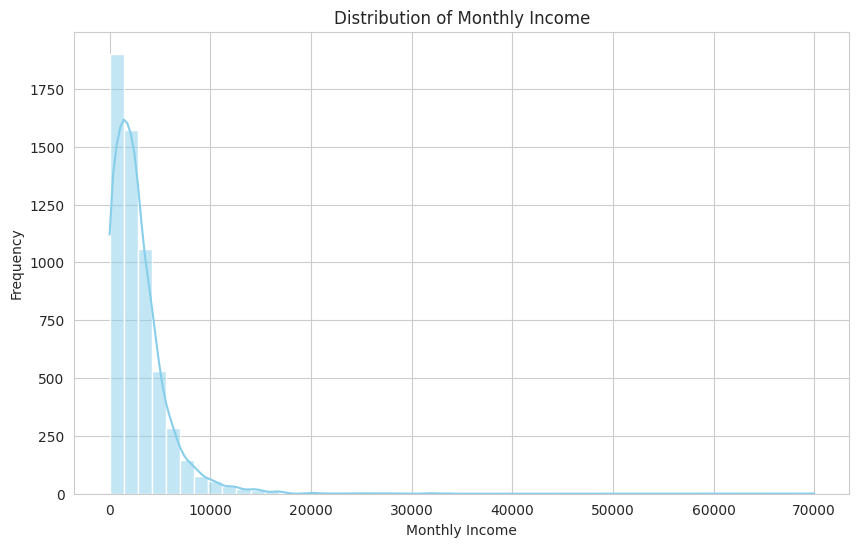

In [ ]:
# plot MonthlyIncome where isn't null and DebtRatio is zero
df = df_train.loc[~((df_train['MonthlyIncome'].isnull())) & (df_train['DebtRatio'] == 1)]
plt.figure(figsize=(10, 6))
sns.histplot(df['MonthlyIncome'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Distribution of Monthly Income')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.show()

Estimating the `MonthlyIncome` based on other features involves building a predictive model. Since `MonthlyIncome` is the target variable, and `DebtRatio`, `RevolvingUtilizationOfUnsecuredLines`, and `age` are features, and use regression models for this task.

Avg. MonthlyIncome:  6766.945009873918
MAE :  3437.9417998655586
MSE :  44766704.426701576
RMSE :  6690.7925111082


Text(0, 0.5, 'Y predictions')

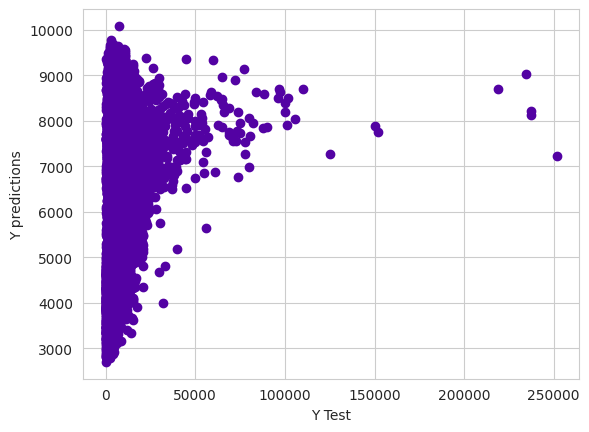

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Assuming df_train is your DataFrame
features = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse']
target = 'MonthlyIncome'

# Split the Data
df = df_train.loc[~(df_train['MonthlyIncome'].isnull()), ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'MonthlyIncome']]
df_test_final = df_train.loc[(df_train['MonthlyIncome'].isnull()), ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'MonthlyIncome']]
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Choose a Regression Model
model = LinearRegression()

# Train the Model
model.fit(X_train, y_train)

# Evaluate the Model
predictions = model.predict(X_test)

print('Avg. MonthlyIncome: ', df['MonthlyIncome'].mean())
print('MAE : ' , metrics.mean_absolute_error(y_test,predictions))
print('MSE : ' , metrics.mean_squared_error(y_test,predictions))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(y_test,predictions)))

plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Y predictions')

In [ ]:
# Assuming trained_model is your trained regression model

# Select features for prediction
features_for_prediction = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse']

# Filter rows with null MonthlyIncome in df_test_final
rows_to_predict = df_test_final[features_for_prediction]

# Predict MonthlyIncome for the selected rows
predicted_monthly_income = model.predict(rows_to_predict)

# Replace null values with predicted values in the original DataFrame
df_train.loc[df_train['MonthlyIncome'].isnull(), 'MonthlyIncome'] = predicted_monthly_income


In [ ]:
null_income_rows = df_train['MonthlyIncome'].isnull().sum()

print("Number of rows where MonthlyIncome is NULL:", null_income_rows)

Number of rows where MonthlyIncome is NULL: 0


In [ ]:
df_train["MonthlyIncome"].describe()

count    1.497310e+05
mean     6.290853e+03
std      1.291442e+04
min      1.000000e+00
25%      3.695000e+03
50%      4.833000e+03
75%      7.500000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [ ]:
# Now you can easily separate them later
train_data = combined_data[combined_data['dataset'] == 'train'].drop('dataset', axis=1)
test_data = combined_data[combined_data['dataset'] == 'test'].drop('dataset', axis=1)

In [27]:
# Calculate IQR
Q1 = combined_data['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)
Q3 = combined_data['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)
IQR = Q3 - Q1

# Identify potential outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
df_no_outliers = combined_data[(combined_data['RevolvingUtilizationOfUnsecuredLines'] >= lower_bound) & (combined_data['RevolvingUtilizationOfUnsecuredLines'] <= upper_bound)]

# Impute outliers with the median
median_value = combined_data['RevolvingUtilizationOfUnsecuredLines'].median()
combined_data['RevolvingUtilizationOfUnsecuredLines'] = combined_data['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)


1.358268053
